# Using Growing Neural Gas

## Import Libraries

In [1]:
import gymnasium as gym
import gym_puddle
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.dqn import MlpPolicy as DQNPolicy
from stable_baselines3.ppo import MlpPolicy as PPOPolicy

import time
import json

import matplotlib.pyplot as plt
import numpy as np

from IPython import display
import pyvirtualdisplay
import cv2

import libs.tiles3 as tc
import random


In [ ]:
import numpy as np
import gym

class GrowingNeuralGas:
    def __init__(self, input_dim, max_nodes=100, epsilon_b=0.05, epsilon_n=0.0006, alpha=0.5, beta=0.999, delta=0.1):
        self.input_dim = input_dim
        self.max_nodes = max_nodes
        self.epsilon_b = epsilon_b
        self.epsilon_n = epsilon_n
        self.alpha = alpha
        self.beta = beta
        self.delta = delta

        # Initialize network with two nodes
        self.nodes = []
        self.nodes.append(Node(input_dim, np.zeros(input_dim)))
        self.nodes.append(Node(input_dim, np.ones(input_dim)))
        self.error = []

    def fit(self, X, epochs=100):
        for epoch in range(epochs):
            np.random.shuffle(X)
            for x in X:
                winner, second_winner = self.find_closest_nodes(x)
                self.update(winner, second_winner, x)
                self.remove_old_connections()

    def find_closest_nodes(self, x):
        distances = [node.distance_to(x) for node in self.nodes]
        winner_index = np.argmin(distances)
        winner = self.nodes[winner_index]
        distances[winner_index] = np.inf
        second_winner_index = np.argmin(distances)
        second_winner = self.nodes[second_winner_index]
        return winner, second_winner

    def update(self, winner, second_winner, x):
        winner.move_towards(x, self.epsilon_b)
        for node in self.nodes:
            node.move_towards(x, self.epsilon_n * node.error)
        self.update_edge_weights(winner)
        self.nodes.append(Node(self.input_dim, x))
        self.remove_old_connections()
        self.error.append(winner.distance_to(x))

    def update_edge_weights(self, winner):
        for edge in winner.edges:
            edge.age += 1
            edge.weight += self.alpha * (edge.source.distance_to(edge.destination.position) - edge.weight)
        for node in self.nodes:
            if node != winner:
                if winner.has_edge_to(node):
                    winner.get_edge_to(node).age = 0
                else:
                    winner.edges.append(Edge(winner, node, 0))

    def remove_old_connections(self):
        edges_to_remove = []
        for node in self.nodes:
            for edge in node.edges:
                if edge.age > self.beta * max([e.age for e in node.edges]):
                    edges_to_remove.append(edge)
        for edge in edges_to_remove:
            edge.source.edges.remove(edge)

class Node:
    def __init__(self, input_dim, position):
        self.position = position
        self.edges = []
        self.error = 0  # Add error attribute and initialize it to 0

    def move_towards(self, x, step_size):
        self.position += step_size * (x - self.position)
        self.error = np.linalg.norm(x - self.position)  # Update error after movement

    def distance_to(self, x):
        return np.linalg.norm(self.position - x)

    def has_edge_to(self, node):
        for edge in self.edges:
            if edge.destination == node:
                return True
        return False

    def get_edge_to(self, node):
        for edge in self.edges:
            if edge.destination == node:
                return edge
        return None

class Edge:
    def __init__(self, source, destination, age):
        self.source = source
        self.destination = destination
        self.age = age
        self.weight = np.linalg.norm(self.source.position - self.destination.position)

# Example usage
if __name__ == "__main__":
    # Define your environment and observation space
    env = gym.make('CartPole-v1')
    observation_space = env.observation_space.shape[0]

    # Create GNG instance
    gng = GrowingNeuralGas(input_dim=observation_space)

    # Generate some random data for training
    data = np.random.rand(100, observation_space)

    # Train the GNG
    gng.fit(data)


In [13]:
import numpy as np
import gym
import networkx as nx

class GNGStateCoder:
    def __init__(self, observation_space: gym.spaces.Space, max_nodes: int = 1000):
        """
        GNG State Coder utilizing Growing Neural Gas algorithm.

        :param observation_space: space to approximate
        :param max_nodes: maximum number of nodes in the GNG graph
        """
        self.graph = nx.Graph()
        self.observation_space = observation_space
        self.max_nodes = max_nodes

    def normalize(self, data: np.ndarray) -> np.ndarray:
        """
        Normalize the data to fit within the observation space.

        :param data: data to normalize
        :return: normalized data
        """
        low = self.observation_space.low
        high = self.observation_space.high
        return (data - low) / (high - low)

    def encode_state(self, observation: np.ndarray) -> np.ndarray:
        """
        Encode observation into the GNG graph.

        :param observation: input observation
        """
        observation = self.normalize(observation)
        self.graph.add_node(tuple(observation), age=0)  # Initialize age attribute for the new node

        if len(self.graph.nodes) > self.max_nodes:
            # If the number of nodes exceeds the limit, remove the oldest node
            oldest_node = min(self.graph.nodes, key=lambda x: self.graph.nodes[x]['age'])
            self.graph.remove_node(oldest_node)

        # Increment age of all existing nodes
        for node in self.graph.nodes:
            if 'age' in self.graph.nodes[node]:  # Check if 'age' attribute exists
                self.graph.nodes[node]['age'] += 1

        # Connect new node to the nearest existing node
        nearest_node = min(self.graph.nodes, key=lambda x: np.linalg.norm(np.array(x) - observation))
        self.graph.add_edge(tuple(observation), nearest_node, age=0)


    def extract_features(self, observation: np.ndarray) -> np.ndarray:
        """
        Extract features from the GNG graph based on the current observation.

        :param observation: input observation
        :return: array representing the position of the nearest node
        """
        observation = self.normalize(observation)
        nearest_node = min(self.graph.nodes, key=lambda x: np.linalg.norm(np.array(x) - observation))
        return np.array(nearest_node)



# Example usage:
observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(2,), dtype=np.float64)
state_coder = GNGStateCoder(observation_space)

# Assuming 'observation' is the current observation
observation = np.array([0.2, 0.7])
state_coder.encode_state(observation)

# Extract features from the encoded state
features = state_coder.extract_features(observation)
print("Active feature indexes:", features)


Active feature indexes: [0.2 0.7]


In [17]:
import numpy as np
import gym
import networkx as nx

class GrowingNeuralGas:
    def __init__(self, observation_space: gym.spaces.Space, max_nodes: int = 100):
        self.observation_space = observation_space
        self.max_nodes = max_nodes
        self.graph = nx.Graph()
        self.dimensions = observation_space.shape[0]
        
        # Initialize the graph with two random nodes
        node1 = self._get_random_observation()
        node2 = self._get_random_observation()
        self.graph.add_node(0, pos=node1, error=0)
        self.graph.add_node(1, pos=node2, error=0)
        self.graph.add_edge(0, 1, age=0)

    def _get_random_observation(self):
        return self.observation_space.sample()

    def _distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2))

    def _closest_nodes(self, current_node):
        distances = [(node, self._distance(current_node, self.graph.nodes[node]['pos'])) for node in self.graph.nodes()]
        distances.sort(key=lambda x: x[1])
        return distances[0][0], distances[1][0]

    def _update_winner(self, current_node):
        winner1, winner2 = self._closest_nodes(current_node)
        winner_pos = self.graph.nodes[winner1]['pos']
        move_delta = 0.05 * (current_node - winner_pos)
        new_pos = winner_pos + move_delta
        self.graph.add_node(winner1, pos=new_pos)

    def encode_observation(self, observation):
        self._update_winner(observation)
        if len(self.graph.nodes()) < self.max_nodes:
            # Add new node every lambda iterations
            if len(self.graph.nodes()) % 100 == 0:
                largest_error_node = max(self.graph.nodes(), key=lambda x: self.graph.nodes[x]['error'])
                # Insert a new unit halfway between largest_error_node and its neighbor
                max_error_neighbor = list(self.graph.neighbors(largest_error_node))[0]
                new_pos = (self.graph.nodes[largest_error_node]['pos'] + self.graph.nodes[max_error_neighbor]['pos']) / 2
                new_node_id = max(self.graph.nodes()) + 1
                self.graph.add_node(new_node_id, pos=new_pos)
                self.graph.add_edge(new_node_id, largest_error_node, age=0)
                self.graph.add_edge(new_node_id, max_error_neighbor, age=0)
                self.graph.remove_edge(largest_error_node, max_error_neighbor)
                self.graph.nodes[largest_error_node]['error'] *= 0.5
                self.graph.nodes[max_error_neighbor]['error'] *= 0.5
        return list(self.graph.nodes())

import gym
import numpy as np

# Create a test environment with a continuous observation space
env = gym.make('Pendulum-v1')
observation_space = env.observation_space

# Create an instance of GrowingNeuralGas
gng = GrowingNeuralGas(observation_space)

# Generate some random observations
observations = [observation_space.sample() for _ in range(1000)]

# Encode each observation using GNG
encoded_observations = [gng.encode_observation(observation) for observation in observations]

# Print the encoded observations
print("Encoded Observations:")
for i, encoded_observation in enumerate(encoded_observations[:10]):
    print("Observation {}: {}".format(i, encoded_observation))


Encoded Observations:
Observation 0: [0, 1]
Observation 1: [0, 1]
Observation 2: [0, 1]
Observation 3: [0, 1]
Observation 4: [0, 1]
Observation 5: [0, 1]
Observation 6: [0, 1]
Observation 7: [0, 1]
Observation 8: [0, 1]
Observation 9: [0, 1]


In [56]:
selected_seed = 0
np.random.seed(0)

## Visualization Functions

In [57]:

#some functions to help the visualization and interaction wit the environment

def visualize(frames, video_name = "/Video/video.mp4"):
    # Saves the frames as an mp4 video using cv2
    video_path = video_name
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(video_path, fourcc, 30, (width, height))
    for frame in frames:
        video_writer.write(frame)
    video_writer.release()

def online_rendering(image):
    #Visualize one frame of the image in a display
    ax.axis('off')
    img_with_frame = np.zeros((image.shape[0]+2, image.shape[1]+2, 3), dtype=np.uint8)
    img_with_frame[1:-1, 1:-1, :] = image
    ax.imshow(img_with_frame)
    display.display(plt.gcf())
    display.clear_output(wait=True)


def prepare_display():
  #Prepares display for onine rendering of the frames in the game
  _display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))
  _ = _display.start()
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.axis('off')


def get_action():
    action = None
    while action not in ["w", "a", "s", "d", "W", "A", "S", "D"]:
        action = input("Enter action (w/a/s/d): ")
    if action == "w":
        return 3
    elif action == "a":
        return 0
    elif action == "s":
        return 2
    elif action == "d":
        return 1

## Accessing Different Environment Configurations

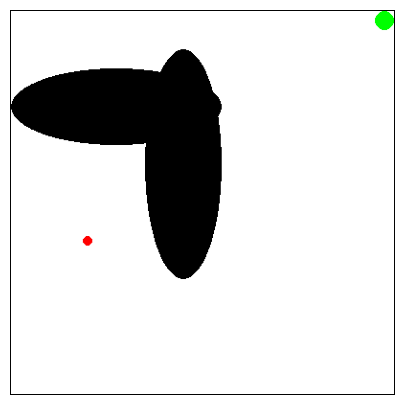

In [58]:
json_file = f"/Users/hadiaghazadeh/Library/CloudStorage/OneDrive-UniversityofCalgary/@upperboundCompetition/gym-puddle/gym_puddle/env_configs/pw1.json"

with open(json_file) as f:
  env_setup = json.load(f)


env = gym.make(
  "PuddleWorld-v0",
  start=env_setup["start"],
  goal=env_setup["goal"],
  goal_threshold=env_setup["goal_threshold"],
  noise=env_setup["noise"],
  thrust=env_setup["thrust"],
  puddle_top_left=env_setup["puddle_top_left"],
  puddle_width=env_setup["puddle_width"],
)


obs, info = env.reset()
image = env.render()
fig, ax = plt.subplots(figsize=(5, 5))

online_rendering(image)

## Environment Details

In [59]:
print("start position:", env.get_wrapper_attr("start"))
print("goal position:", env.get_wrapper_attr("goal"))
print("goal threshold:", env.get_wrapper_attr("goal_threshold"))
print("action noise:", env.get_wrapper_attr("noise"))
print("agent's thrust:", env.get_wrapper_attr("thrust"))
print("puddle top left positions:", env.get_wrapper_attr("puddle_top_left"))
print("puddle widths and heights:", env.get_wrapper_attr("puddle_width"))
print("action space:", env.get_wrapper_attr("actions"))
print("observation space:", env.get_wrapper_attr("observation_space"))

start position: [0.2 0.4]
goal position: [1. 1.]
goal threshold: 0.1
action noise: 0
agent's thrust: 0.05
puddle top left positions: [array([0.  , 0.85]), array([0.35, 0.9 ])]
puddle widths and heights: [array([0.55, 0.2 ]), array([0.2, 0.6])]
action space: [array([-0.05,  0.  ]), array([0.05, 0.  ]), array([ 0.  , -0.05]), array([0.  , 0.05])]
observation space: Box(0.0, 1.0, (2,), float64)


## Kanerva coding

In [60]:
from util.kanerva import BaseKanervaCoder
num_features = 1000
n_closest = 10
rep = BaseKanervaCoder(env.observation_space, n_prototypes= num_features, n_closest= n_closest, random_seed= selected_seed)
rep.get_features(obs)

array([820, 286, 117, 555, 408, 278, 592,  32, 673, 241])

## Q-learning

In [61]:
class tabularQlearning:
    def __init__(self, num_feature, num_actions, alpha=0.1, gamma=0.9, epsilon=0.05, seed = selected_seed):
        self.num_feature = num_feature
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-table with zeros
        self.q_table = np.zeros((self.num_feature, num_actions))

        self.seed = seed    
        # Set random seed
        np.random.seed(self.seed)

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            q = self.q_table[state].sum(axis=0)
            return q.argmax()
    
    def update(self, state, action, reward, next_state):
        """Update the Q-table using the Q-learning update rule"""
        self.q_table[state, action] += self.alpha * (reward + self.gamma * np.max(self.q_table[next_state]) - self.q_table[state, action])
    
    def get_q_table(self):
        return self.q_table

In [62]:
## simulare the agent in the environment
num_actions = len(env.get_wrapper_attr("actions"))
agent = tabularQlearning(num_feature= num_features, num_actions=num_actions)

num_episodes = 15000

for episode in range(num_episodes):
    obs, info = env.reset()
    state = rep.get_features(obs)
    done = False
    total_reward = 0
    while not done:
        action = agent.choose_action(state)
        next_obs, reward, done, trunc, _ = env.step(action)
        next_state = rep.get_features(next_obs)
        agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    if episode % 20 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")


Episode 0, Total Reward: -2208.0
Episode 20, Total Reward: -579
Episode 40, Total Reward: -32258.0
Episode 60, Total Reward: -4528.0
Episode 80, Total Reward: -396.0
Episode 100, Total Reward: -61
Episode 120, Total Reward: -73
Episode 140, Total Reward: -489
Episode 160, Total Reward: -75
Episode 180, Total Reward: -63
Episode 200, Total Reward: -35
Episode 220, Total Reward: -51
Episode 240, Total Reward: -82
Episode 260, Total Reward: -35
Episode 280, Total Reward: -37
Episode 300, Total Reward: -37
Episode 320, Total Reward: -43
Episode 340, Total Reward: -33
Episode 360, Total Reward: -33
Episode 380, Total Reward: -43
Episode 400, Total Reward: -39
Episode 420, Total Reward: -432.0
Episode 440, Total Reward: -37
Episode 460, Total Reward: -43
Episode 480, Total Reward: -33
Episode 500, Total Reward: -35
Episode 520, Total Reward: -39
Episode 540, Total Reward: -37
Episode 560, Total Reward: -380.0
Episode 580, Total Reward: -35
Episode 600, Total Reward: -33
Episode 620, Total Re

## Test the trained model

In [63]:

#Test the trained model
obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []
observation = obs

max_video_length = 120


def greedy_policy(state):
    state_index = agent.encode_state(state)
    return np.argmax(agent.q_table[state_index])

for time_step in range(max_video_length):
    
    frames.append(env.render())

    #action = greedy_policy(get_features(observation))
    action = agent.choose_action(rep.get_features(observation))
    observation, reward, done, trunc, _ = env.step(action)
    total_reward += reward
    image = env.render()
    #online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {observation}, reward: {reward}") #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "./Video/q_learning_Kan.mp4")

 t: 0, observation: [0.2  0.35], reward: -1
 t: 1, observation: [0.2 0.3], reward: -1
 t: 2, observation: [0.2  0.25], reward: -1
 t: 3, observation: [0.2 0.2], reward: -1
 t: 4, observation: [0.25 0.2 ], reward: -1
 t: 5, observation: [0.3 0.2], reward: -1
 t: 6, observation: [0.35 0.2 ], reward: -1
 t: 7, observation: [0.4 0.2], reward: -1
 t: 8, observation: [0.45 0.2 ], reward: -1
 t: 9, observation: [0.5 0.2], reward: -1
 t: 10, observation: [0.55 0.2 ], reward: -1
 t: 11, observation: [0.6 0.2], reward: -1
 t: 12, observation: [0.55 0.2 ], reward: -1
 t: 13, observation: [0.6 0.2], reward: -1
 t: 14, observation: [0.65 0.2 ], reward: -1
 t: 15, observation: [0.65 0.25], reward: -1
 t: 16, observation: [0.65 0.3 ], reward: -1
 t: 17, observation: [0.65 0.35], reward: -1
 t: 18, observation: [0.65 0.4 ], reward: -1
 t: 19, observation: [0.6 0.4], reward: -1
 t: 20, observation: [0.6  0.45], reward: -1
 t: 21, observation: [0.6 0.5], reward: -1
 t: 22, observation: [0.6  0.55], rewa

## Q-Learning with Eligibility Trace

In [16]:
class tabularQlearningET:
    def __init__(self, num_feature, num_actions, alpha=0.1, gamma=0.99, epsilon=0.1, lambda_=0.9, seed = selected_seed):
        self.num_feature = num_feature
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambda_ = lambda_

        # Initialize Q-table with zeros
        self.q_table = np.zeros((self.num_feature, num_actions))
        self.eligibility = np.zeros(self.num_feature)

        self.seed = seed
        # Set random seed
        np.random.seed(self.seed)

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            q = self.q_table[state].sum(axis=0)
            return q.argmax()
    
    def update(self, state, action, reward, next_state):
        self.eligibility *= self.gamma * self.lambda_
        self.eligibility[state] =1

        v_next = self.gamma * self.q_table[next_state].sum(axis=0).max()

        td_error = reward + v_next - self.q_table[state, action].sum()

        alpha = self.alpha / len(state)

        self.q_table[:, action] += alpha * td_error * self.eligibility

    def erase_eligibility(self):
        self.eligibility = np.zeros(self.num_feature)
        
    def get_q_table(self):
        return self.q_table

In [17]:
## simulare the agent in the environment
num_actions = len(env.get_wrapper_attr("actions"))
agent = tabularQlearningET(num_feature= num_features, num_actions=num_actions)

num_episodes = 10000

for episode in range(num_episodes):
    obs, info = env.reset()
    state = rep.get_features(obs)
    done = False
    total_reward = 0
    agent.erase_eligibility()
    while not done:
        action = agent.choose_action(state)
        next_obs, reward, done, trunc, _ = env.step(action)
        next_state = rep.get_features(next_obs)
        agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    if episode % 20 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")


Episode 0, Total Reward: -2689.912530835113
Episode 20, Total Reward: -72
Episode 40, Total Reward: -44
Episode 60, Total Reward: -56
Episode 80, Total Reward: -64
Episode 100, Total Reward: -74
Episode 120, Total Reward: -66
Episode 140, Total Reward: -66
Episode 160, Total Reward: -376
Episode 180, Total Reward: -74
Episode 200, Total Reward: -52
Episode 220, Total Reward: -55
Episode 240, Total Reward: -48
Episode 260, Total Reward: -41
Episode 280, Total Reward: -44
Episode 300, Total Reward: -50
Episode 320, Total Reward: -278.1864330418383
Episode 340, Total Reward: -49
Episode 360, Total Reward: -54
Episode 380, Total Reward: -46
Episode 400, Total Reward: -44
Episode 420, Total Reward: -48
Episode 440, Total Reward: -50
Episode 460, Total Reward: -52
Episode 480, Total Reward: -47
Episode 500, Total Reward: -43
Episode 520, Total Reward: -44
Episode 540, Total Reward: -43
Episode 560, Total Reward: -48
Episode 580, Total Reward: -45
Episode 600, Total Reward: -42
Episode 620, T

In [21]:
obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []
observation = obs

max_video_length = 120


for time_step in range(max_video_length):
    frames.append(env.render())

    #action = greedy_policy(get_features(observation))
    action = agent.choose_action(rep.get_features(observation))
    observation, reward, done, trunc, _ = env.step(action)
    total_reward += reward
    image = env.render()
    #online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {observation}, reward: {reward}") #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "./Video/q_learning_Kan_ET.mp4")

 t: 0, observation: [0.20286288 0.34125826], reward: -1
 t: 1, observation: [0.24526551 0.33682478], reward: -1
 t: 2, observation: [0.24115111 0.28597662], reward: -1
 t: 3, observation: [0.24857013 0.24874332], reward: -1
 t: 4, observation: [0.24405617 0.20384785], reward: -1
 t: 5, observation: [0.249758   0.25979119], reward: -1
 t: 6, observation: [0.24375847 0.22434944], reward: -1
 t: 7, observation: [0.2451925  0.17720605], reward: -1
 t: 8, observation: [0.30637279 0.15724924], reward: -1
 t: 9, observation: [0.36446822 0.15213001], reward: -1
 t: 10, observation: [0.40841844 0.16233217], reward: -1
 t: 11, observation: [0.35921752 0.16504246], reward: -1
 t: 12, observation: [0.40835509 0.16760173], reward: -1
 t: 13, observation: [0.4116669  0.21085044], reward: -1
 t: 14, observation: [0.36832805 0.20767923], reward: -1
 t: 15, observation: [0.42826317 0.21118161], reward: -1
 t: 16, observation: [0.35851445 0.21728525], reward: -1
 t: 17, observation: [0.37766765 0.177604